# NLP Clissification
---
**Dataset:** bbc news (250 samples) News contents with 5 categories (Sport, Business, Politics, Tech and Others)

**Model:**   multiclass classification model : ELMO

**Training:**  Colab (GPU)  tensorflow version : 1.14.0  keras version : 2.2.4

**Process:**  1. Dataset Load  ➔ 2. Data processing ➔ 3. Model Training  ➔ 4. Model Evaluation 

**Result:**  Accuracy = 0.83, Run time  1 minute


## 0. Environment

In [ ]:
# Based Library
import tensorflow as tf; print("tensorflow version : " + tf.__version__)
import keras; print("keras version : " + keras.__version__)

tensorflow version : 1.14.0
keras version : 2.2.4


Using TensorFlow backend.


In [ ]:
# Processor

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1111970186520276725
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11215541927519412103
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18216800849485848080
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 12058299597
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7240388198450936959
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## 1. Dataset Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# intent, unique_intent, sentencesに分ける
import pandas as pd

def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
  print(df.head())
  intent = df["Intent"]
  unique_intent = list(set(intent))
  sentences = list(df["Sentence"])
  
  return (df, intent, unique_intent, sentences)

In [ ]:
# データ読み込

dataset = "/content/drive/My Drive/dataset/chat_intent1/Dataset.csv"
data, intent, unique_intent, sentences = load_dataset(dataset)

                Sentence          Intent
0       Need help pleese  commonQ.assist
1              Need help  commonQ.assist
2       I need some info  commonQ.assist
3      Will you help me?  commonQ.assist
4  What else can you do?  commonQ.assist


In [ ]:
data.head()

,Sentence,Intent
0,Need help pleese,commonQ.assist
1,Need help,commonQ.assist
2,I need some info,commonQ.assist
3,Will you help me?,commonQ.assist
4,What else can you do?,commonQ.assist


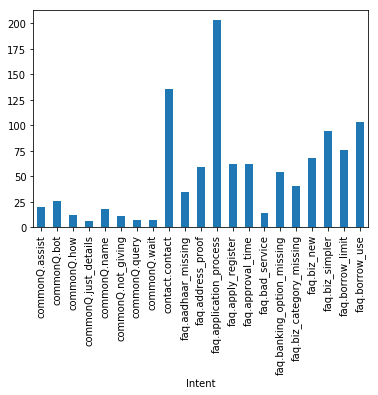

In [ ]:
import matplotlib.pyplot as plt

data.groupby('Intent').Sentence.count().plot.bar(ylim=0)
plt.show()

## 2. Data Processing

In [ ]:
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame()
df["text"] = data["Sentence"]
df["label"] = LabelEncoder().fit_transform(data["Intent"])

In [ ]:
df.head()

,text,label
0,Need help pleese,0
1,Need help,0
2,I need some info,0
3,Will you help me?,0
4,What else can you do?,0


In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df.head()

,text,label
0,Need help pleese,0
1,Need help,0
2,I need info,0
3,Will help me?,0
4,What else do?,0


In [ ]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [ ]:
df.head()

,text,label
0,Need help pleese,0
1,Need help,0
2,I need info,0
3,Will help me?,0
4,What else do?,0


In [ ]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import re
import time
import pickle
pd.set_option('display.max_colwidth', 200)

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [ ]:
%time
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np

x = list(df['text'])
y = list(df['label'])

le = preprocessing.LabelEncoder()
le.fit(y)

def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

x_enc = x
y_enc = encode(le, y)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.asarray(x_enc), np.asarray(y_enc), test_size=0.2, random_state=42)

print("x_train count : ", len(x_train))
print("x_test count : ", len(x_test))

x_train count :  890
x_test count :  223


## 3. Model Training

In [ ]:
from datetime import datetime
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

start_time = datetime.now()

intent_range = len(unique_intent)

def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(intent_range, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(x_train, y_train, epochs=1, batch_size=16)
    model.save_weights('./elmo-model.h5')

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')  
    predicts = model.predict(x_test, batch_size=16)

y_test = decode(le, y_test)
y_preds = decode(le, predicts)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

W0727 12:41:18.347917 140180973406080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0727 12:41:18.394479 140180973406080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/1
890/890 [==============================] - 7s 7ms/step - loss: 1.4132 - acc: 0.6247
Duration: 0:00:09.479465


## 4. Model Evaluation

In [ ]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test, y_preds))

print(metrics.classification_report(y_test, y_preds))

from sklearn.metrics import accuracy_score

print("Accuracy of ELMO is:",accuracy_score(y_test,y_preds))

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0 12  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 38  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  5  9  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0]
 [ 0  0  0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
